<a href="https://colab.research.google.com/github/FKz11/test_tasks/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание

## Библиотеки

In [1]:
!pip install -q catboost
!pip install -q shap

     |████████████████████████████████| 76.6 MB 88 kB/s 
     |████████████████████████████████| 569 kB 4.3 MB/s 


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import json

from catboost import CatBoostRegressor
import shap

## Загрузка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/us events ad_revenue filtered 03.02-07.02.csv")
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte


In [5]:
df.shape

(860079, 16)

## Обработка и первичный анализ данных

### Раскроем event_json

In [6]:
df = pd.concat([df, pd.json_normalize(df['event_json'].apply(json.loads))], axis=1).drop('event_json', axis=1)
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,...,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,...,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,...,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58


In [7]:
df.shape

(860079, 32)

### Пропущенные даннные

In [8]:
df.isnull().sum()

profile_id                     14
os_version                      0
device_manufacturer             0
device_model                    0
device_type                     0
device_locale                   0
event_name                      0
event_datetime                  0
event_timestamp                 0
event_receive_datetime          0
event_receive_timestamp         0
connection_type                 0
operator_name               18879
country_iso_code                0
city                       323708
ad_type                         0
placement                       0
view_index                      0
session_view_index              0
cur_ticks                       0
session_length                  0
revenue                         0
ads_ltv                         0
ecpm_sma                        0
normalized_ecpm_sma             0
value                           0
currency                        0
ad_country_code                 0
network_name                    0
ad_unit_id    

### Упростим profile_id

In [9]:
profile_id_TO_new_id = dict(zip(set(df['profile_id']), map(str, range(len(set(df['profile_id']))))))
dict(list(profile_id_TO_new_id.items())[:5])

{'JL5QoqsuOiU': '4',
 'JLmPd7U6zCN': '2',
 'JLotMik2KS6': '3',
 'JLz5n0cZWzL': '1',
 nan: '0'}

In [10]:
new_id_TO_profile_id = dict(zip(map(str, range(len(set(df['profile_id'])))), set(df['profile_id'])))
dict(list(new_id_TO_profile_id.items())[:5])

{'0': nan,
 '1': 'JLz5n0cZWzL',
 '2': 'JLmPd7U6zCN',
 '3': 'JLotMik2KS6',
 '4': 'JL5QoqsuOiU'}

In [11]:
df['profile_id'] = df['profile_id'].apply(lambda x: profile_id_TO_new_id[x])
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,...,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,1592,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,...,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,1592,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,...,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,2165,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,...,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58


### Произведём линейное преобразование: eCPM = revenue * 1000

In [12]:
df['eCPM'] = df['revenue'] * 1000
df = df.drop('revenue', axis=1)
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,...,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId,eCPM
0,1592,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,...,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ,0.510313
1,1592,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,...,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ,0.510313
2,2165,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,...,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58,2.386163


### Отсортируем по времени

In [13]:
df = df.sort_values('event_datetime')
df.head(3)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,...,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId,eCPM
21345,2200,11,Samsung,Galaxy S10e,phone,en_US,c_ad_revenue,2022-01-29 17:42:32,1643467352,2022-02-03 01:27:18,...,2.170027,2.170027,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-57,2.386163
827376,2049,11,Samsung,Galaxy A51,phone,en_US,c_ad_revenue,2022-01-29 18:01:54,1643468514,2022-02-03 18:44:12,...,30.026268,30.764618,0.012451,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13321880,12.451473
783920,618,7.0,LG,LG K20 Plus,phone,en_US,c_ad_revenue,2022-01-29 23:05:37,1643486737,2022-02-03 12:40:45,...,0.760236,0.760236,0.000300,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,COHVkpTh1_UCFZYSrQYdsB8Nrw,0.300000


### Типы данных

In [14]:
df.dtypes

profile_id                  object
os_version                  object
device_manufacturer         object
device_model                object
device_type                 object
device_locale               object
event_name                  object
event_datetime              object
event_timestamp              int64
event_receive_datetime      object
event_receive_timestamp      int64
connection_type             object
operator_name               object
country_iso_code            object
city                        object
ad_type                     object
placement                   object
view_index                   int64
session_view_index           int64
cur_ticks                    int64
session_length             float64
ads_ltv                    float64
ecpm_sma                   float64
normalized_ecpm_sma        float64
value                      float64
currency                    object
ad_country_code             object
network_name                object
ad_unit_id          

### Описательная статистика числовых данных



In [15]:
df.describe()

,event_timestamp,event_receive_timestamp,view_index,session_view_index,cur_ticks,session_length,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,eCPM
count,8.600790e+05,8.600790e+05,860079.000000,860079.000000,8.600790e+05,860079.000000,860079.000000,860079.000000,860079.000000,860079.000000,860079.000000
mean,1.644088e+09,1.644088e+09,2.049220,0.241736,6.377966e+17,5730.505424,1.417849,3.147110,3.227661,0.002780,2.779743
std,1.058604e+05,1.055928e+05,9.682474,1.743580,1.060356e+12,15342.189669,2.119035,15.973978,16.433888,0.015129,15.128594
min,1.643467e+09,1.643836e+09,1.000000,0.000000,6.377900e+17,2.208125,0.000026,0.001014,0.001014,0.000000,0.000000
25%,1.644017e+09,1.644018e+09,1.000000,0.000000,6.377959e+17,512.645300,0.268843,0.139942,0.139942,0.000046,0.046083
50%,1.644102e+09,1.644103e+09,1.000000,0.000000,6.377968e+17,1398.315000,0.682342,0.480991,0.480991,0.000494,0.494196
75%,1.644177e+09,1.644177e+09,1.000000,0.000000,6.377975e+17,4095.932000,1.599739,0.772006,0.772006,0.000533,0.533385
max,1.644268e+09,1.644268e+09,417.000000,74.000000,6.378005e+17,394117.600000,26.699762,908.876160,917.695618,0.937196,937.195984


## Задания

### 1а 

### Для каждого формата рекламы построить распределение средних eCPM-ов юзеров:

In [16]:
t_1a = df.groupby(['ad_type', 'profile_id']).eCPM.mean().sort_values(ascending=False)
t_1a.head(3)

ad_type  profile_id
rv       3707          808.294820
         4087          693.534973
         311           601.758453
Name: eCPM, dtype: float64

In [17]:
ad_types = t_1a.index.levels[0]
ad_types

Index(['banner', 'int', 'rv'], dtype='object', name='ad_type')

In [18]:
def ad_type_eCPM_plots(ad_types, table, top_n=None, xtick=True, logy=False):

  fig, axs = plt.subplots(nrows=len(ad_types), figsize=(30, 15))

  for i in range(len(ad_types)):
    
    axs[i].set_title(ad_types[i], fontsize=25)
    axs[i].set_xlabel(table.index.names[1], fontsize=18)
    axs[i].set_ylabel('eCPM', fontsize=18)
    axs[i].bar(table[ad_types[i]][:top_n].index, table[ad_types[i]][:top_n].values)
    if logy:
      axs[i].set_yscale('log')
    if not xtick:
      axs[i].set_xticklabels([])
    plt.subplots_adjust(hspace=0.5)

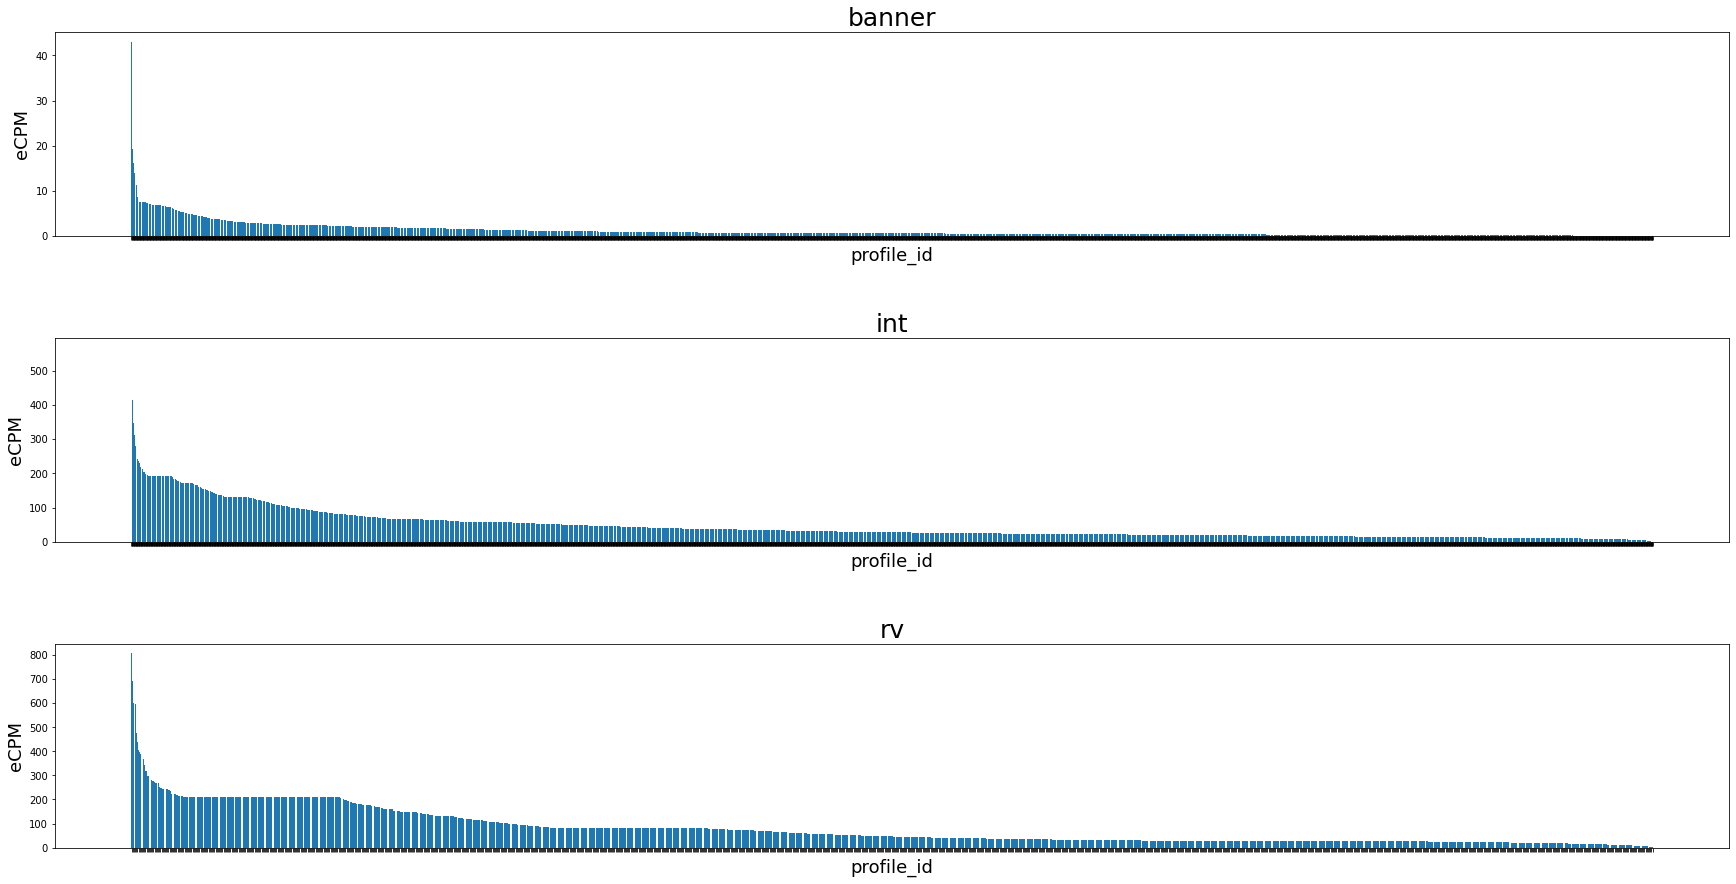

In [19]:
ad_type_eCPM_plots(ad_types, t_1a, xtick=False)

Посмотрим для топ n пользователей для каждого формата рекламы

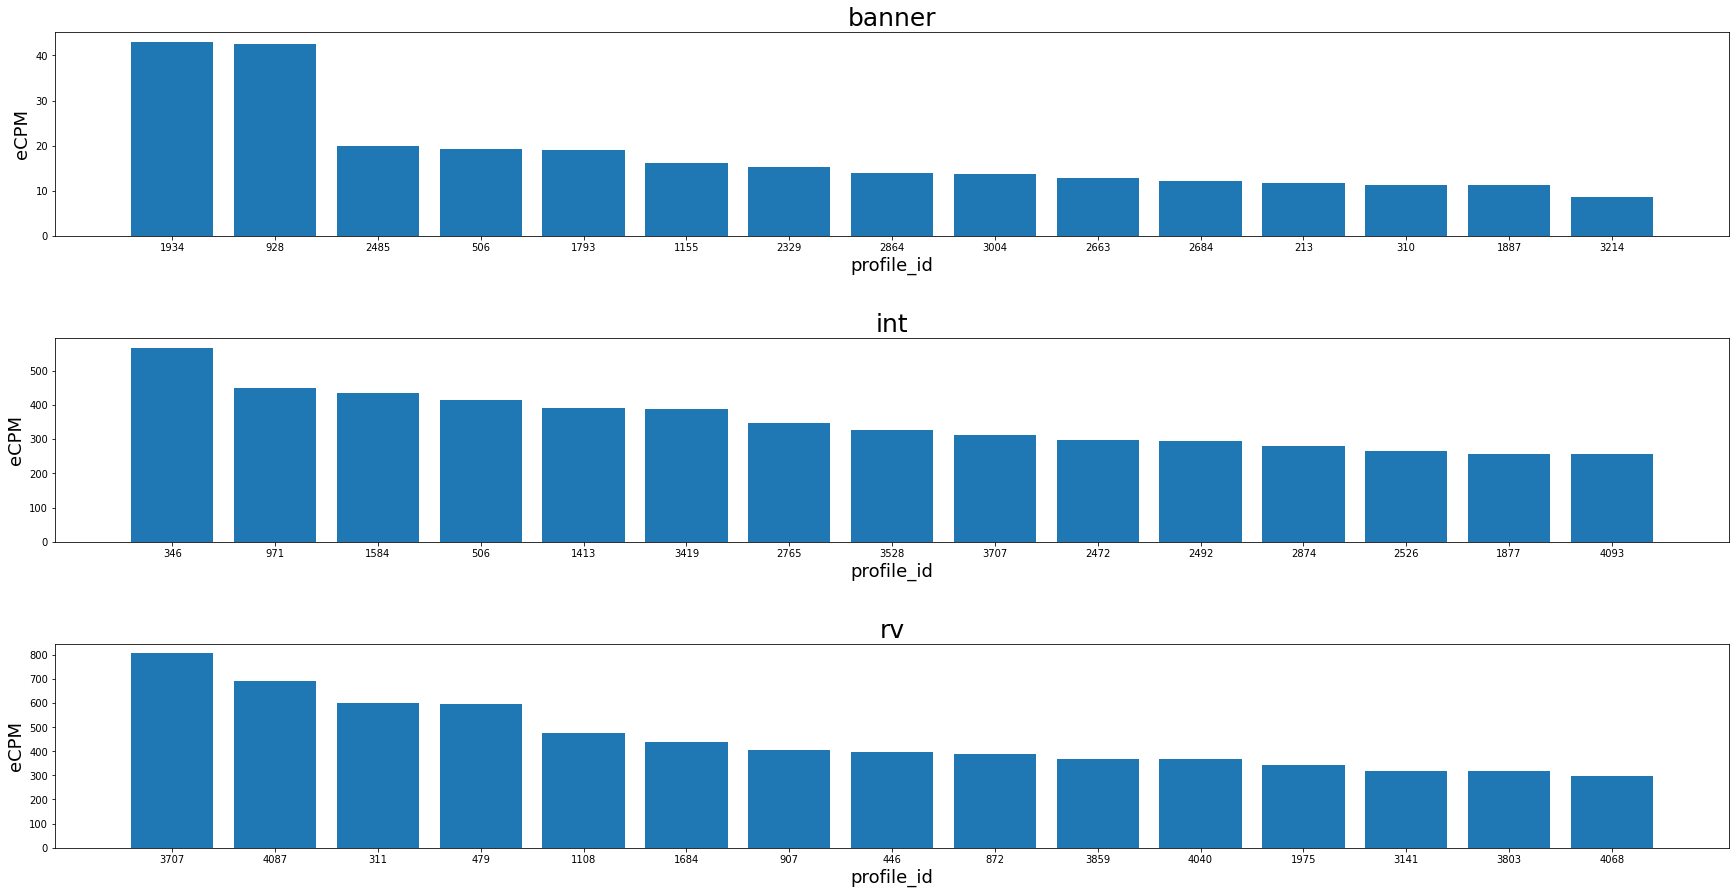

In [20]:
ad_type_eCPM_plots(ad_types, t_1a, top_n=15)

Найдем средние eCPM для каждого формата рекламы

In [21]:
ad_type_eCPM = df.groupby('ad_type').eCPM.mean().sort_values(ascending=False)
ad_type_eCPM

ad_type
rv        65.051165
int       36.209634
banner     0.744113
Name: eCPM, dtype: float64

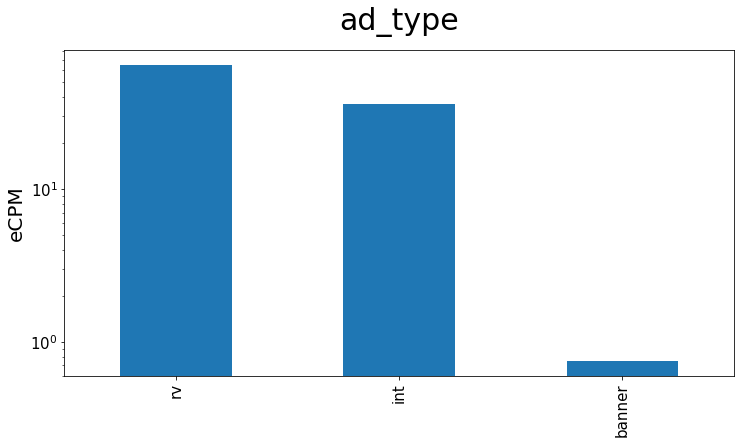

In [22]:
ad_type_eCPM.plot(kind='bar', logy = True, fontsize = 15, figsize=(12, 6))
plt.xlabel("")
plt.ylabel("eCPM", fontsize=20)
plt.title('ad_type', fontsize=30, pad=20)
plt.show()

Видно, что видео, которое юзер смотрит по желанию(rv) и полноэкранная реклама(int) приносят во много раз больше дохода, чем горизонтальный баннер внизу
экрана(banner). Так же лидером по доходу является видео, которое юзер смотрит по желанию(rv).

### 1b 

### Для каждого формата рекламы отобразить средние eCPM-ы по городам, версиям ОС:

По городам:

In [23]:
t_1b_city = df.groupby(['ad_type', 'city']).eCPM.mean().sort_values(ascending=False)
t_1b_city.head(3)

ad_type  city        
rv       East Peoria     808.294820
         Norwood         597.984497
int      Madisonville    437.039882
Name: eCPM, dtype: float64

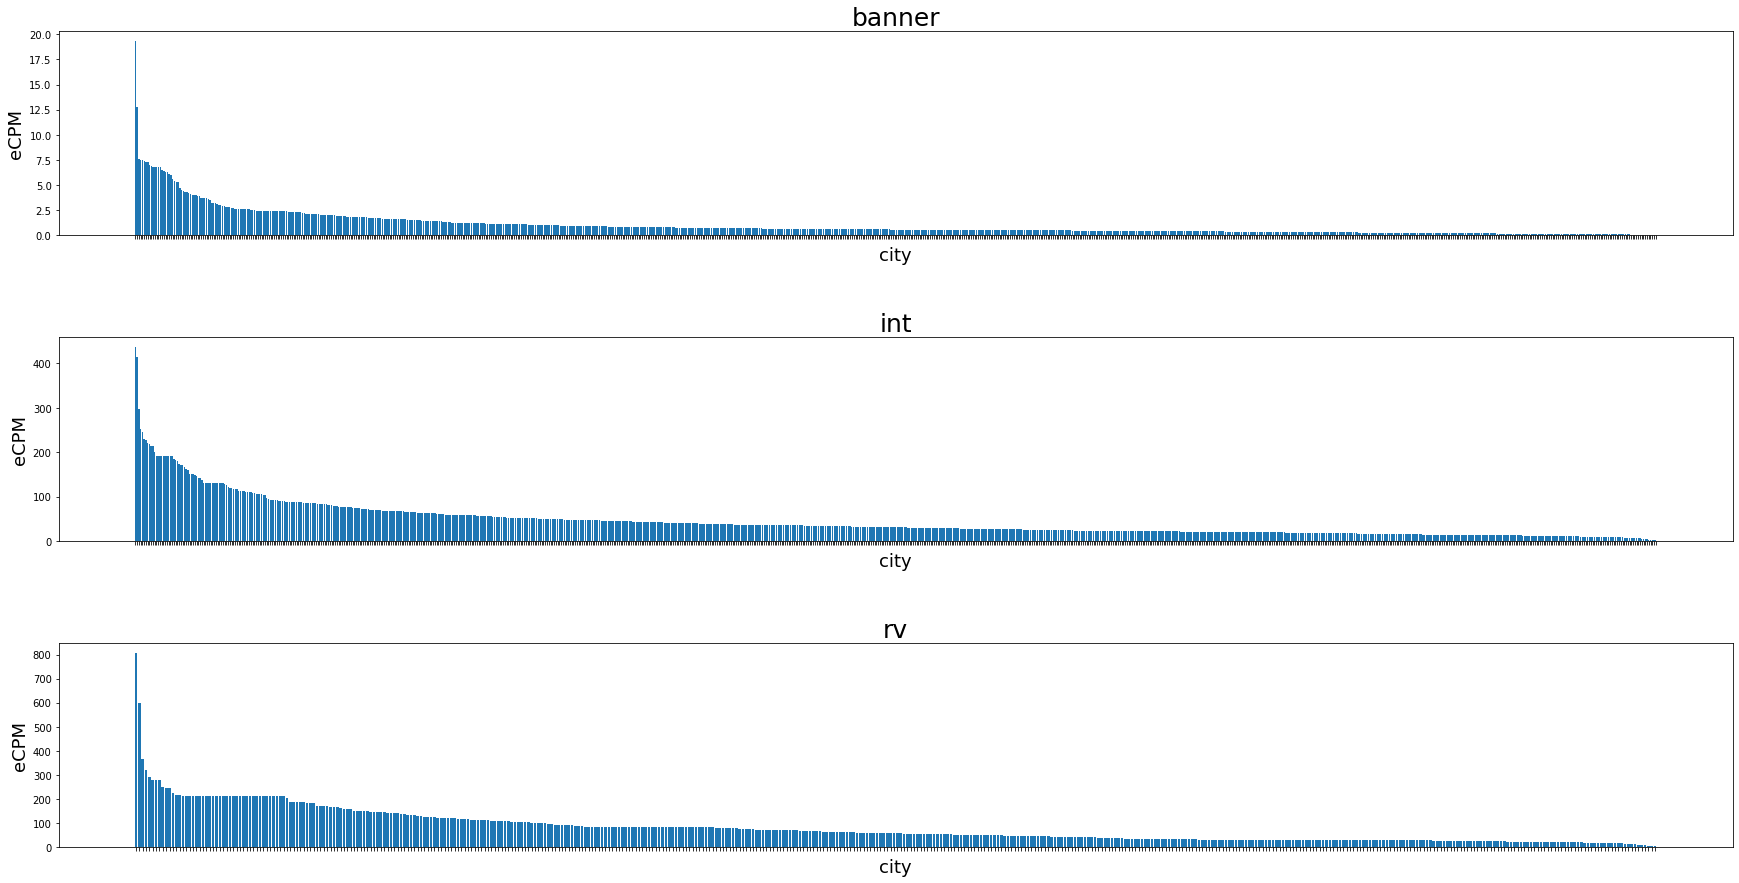

In [24]:
ad_type_eCPM_plots(ad_types, t_1b_city, xtick=False)

Посмотрим для топ n городов для каждого формата рекламы

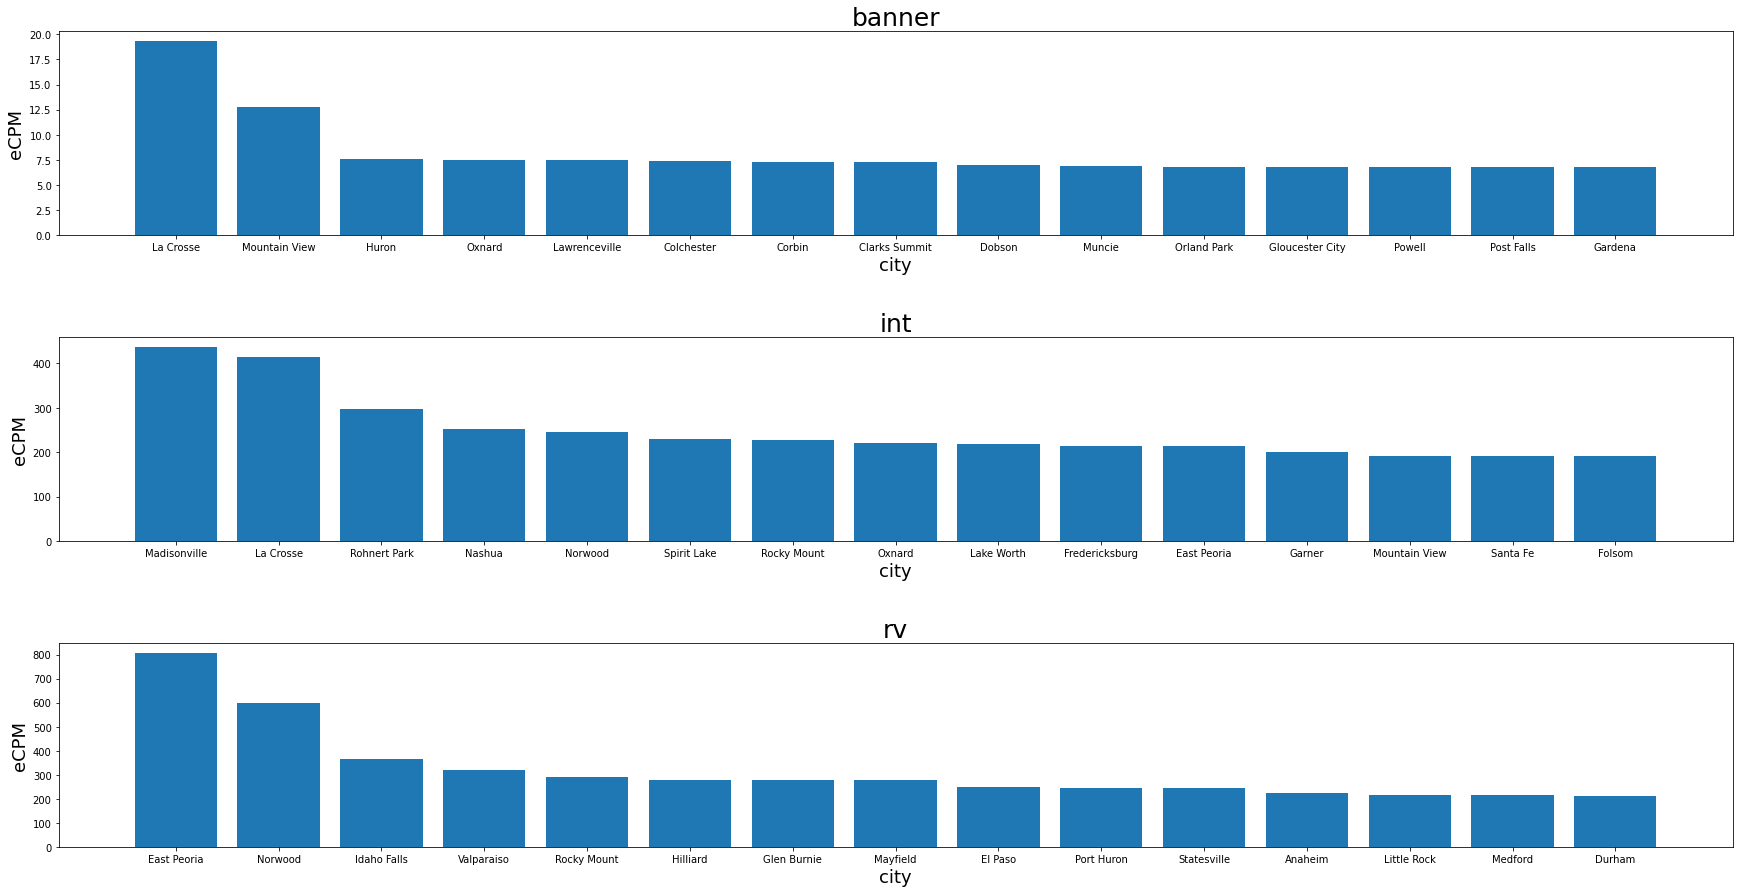

In [25]:
ad_type_eCPM_plots(ad_types, t_1b_city, top_n=15)

По версиям ОС:

In [26]:
t_1b_os = df.groupby(['ad_type', 'os_version']).eCPM.mean().sort_values(ascending=False)
t_1b_os

ad_type  os_version
rv       7.0           79.662468
         12            79.568911
         11            53.378872
         10            53.336882
         9             50.151552
int      12            42.391070
         7.0           39.266162
rv       8.0.0         38.614653
int      11            33.468471
rv       8.1.0         31.830249
int      10            31.216643
         9             27.004733
rv       7.1.1         24.215299
int      8.0.0         20.030134
         7.1.1         18.232767
         8.1.0         17.694561
         5.0.2         14.969333
rv       5.0.2         14.188713
int      6.0.1         13.172003
         7.1.2         11.964031
rv       6.0.1          9.191038
banner   12             0.936871
         11             0.592766
         10             0.591274
         9              0.549553
         8.0.0          0.368201
         8.1.0          0.320697
         7.0            0.278132
         6.0.1          0.254481
         7.1.1         

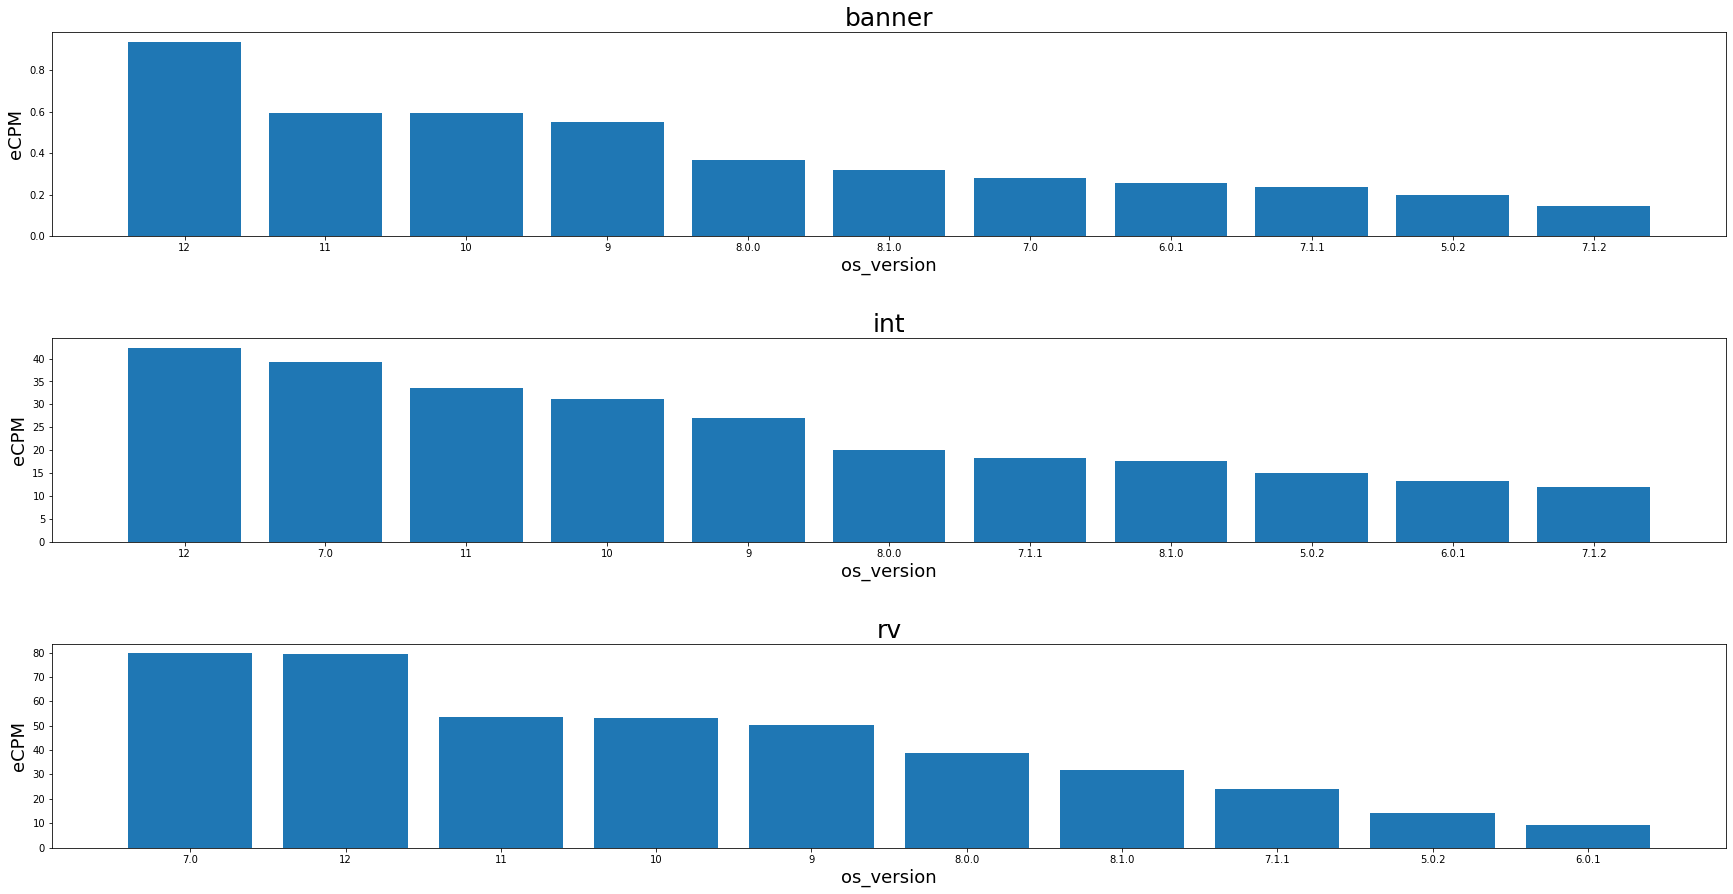

In [27]:
ad_type_eCPM_plots(ad_types, t_1b_os)

### 1c 

### Для каждого формата рекламы отобразить суммарные доходы по городам, версиям ОС:

По городам:

In [28]:
t_1c_city = df.groupby(['ad_type', 'city']).eCPM.sum().sort_values(ascending=False)
t_1c_city.head(3)

ad_type  city        
int      New York        25674.272255
         Indianapolis    21534.430700
         Cleveland       18112.860745
Name: eCPM, dtype: float64

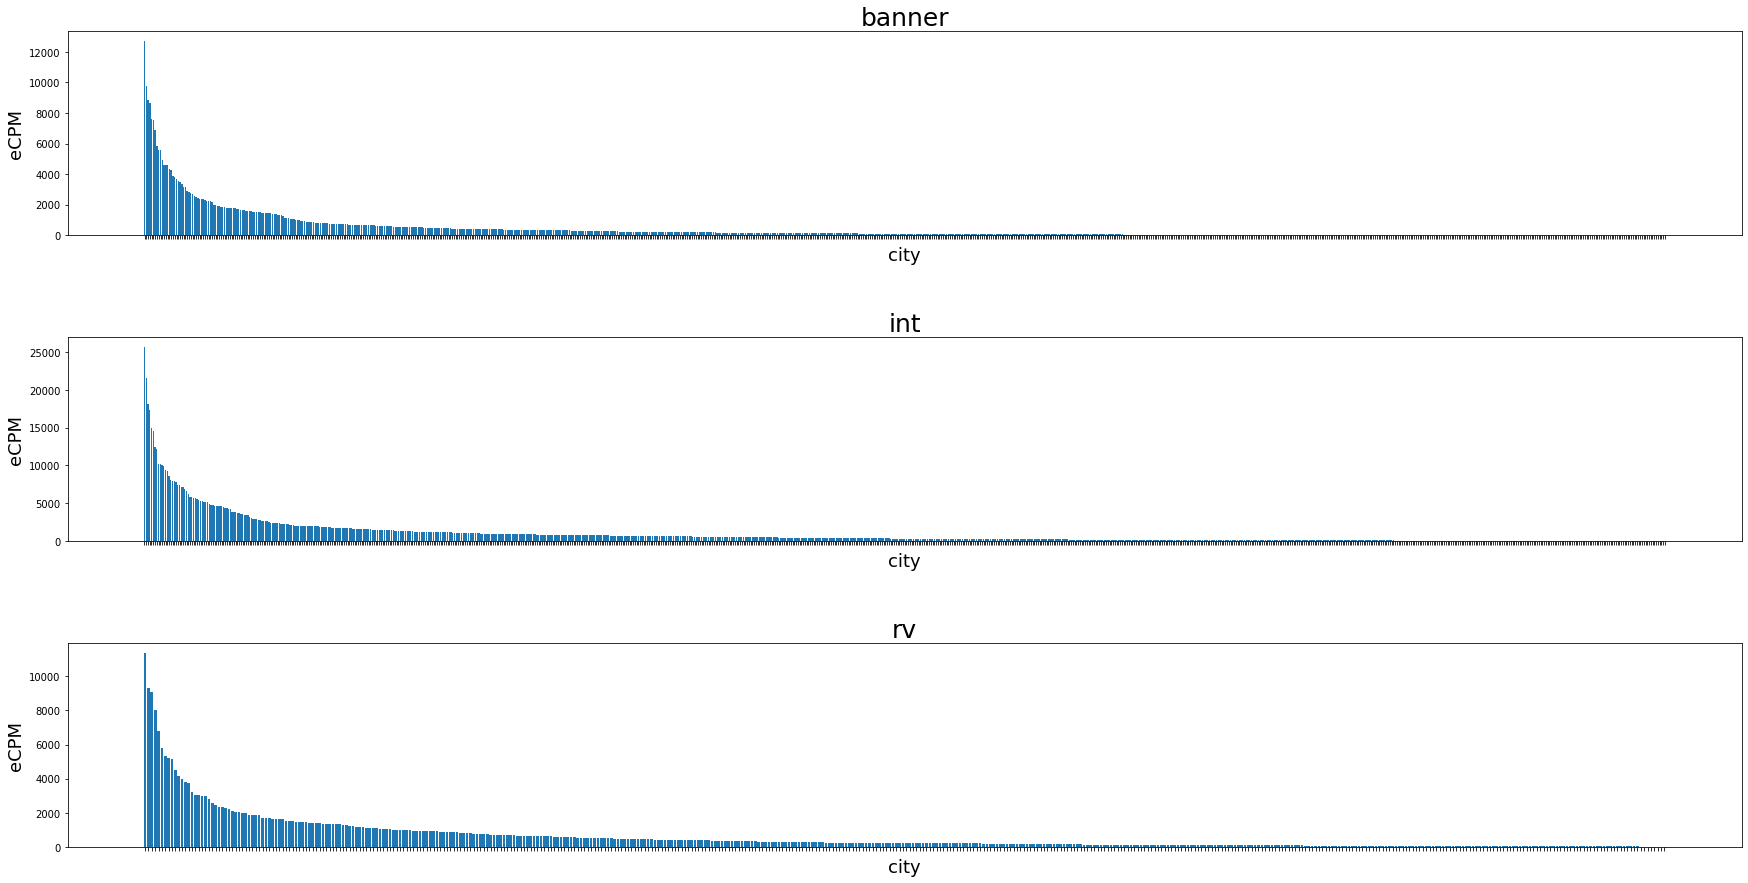

In [29]:
ad_type_eCPM_plots(ad_types, t_1c_city, xtick=False)

Посмотрим для топ n городов для каждого формата рекламы

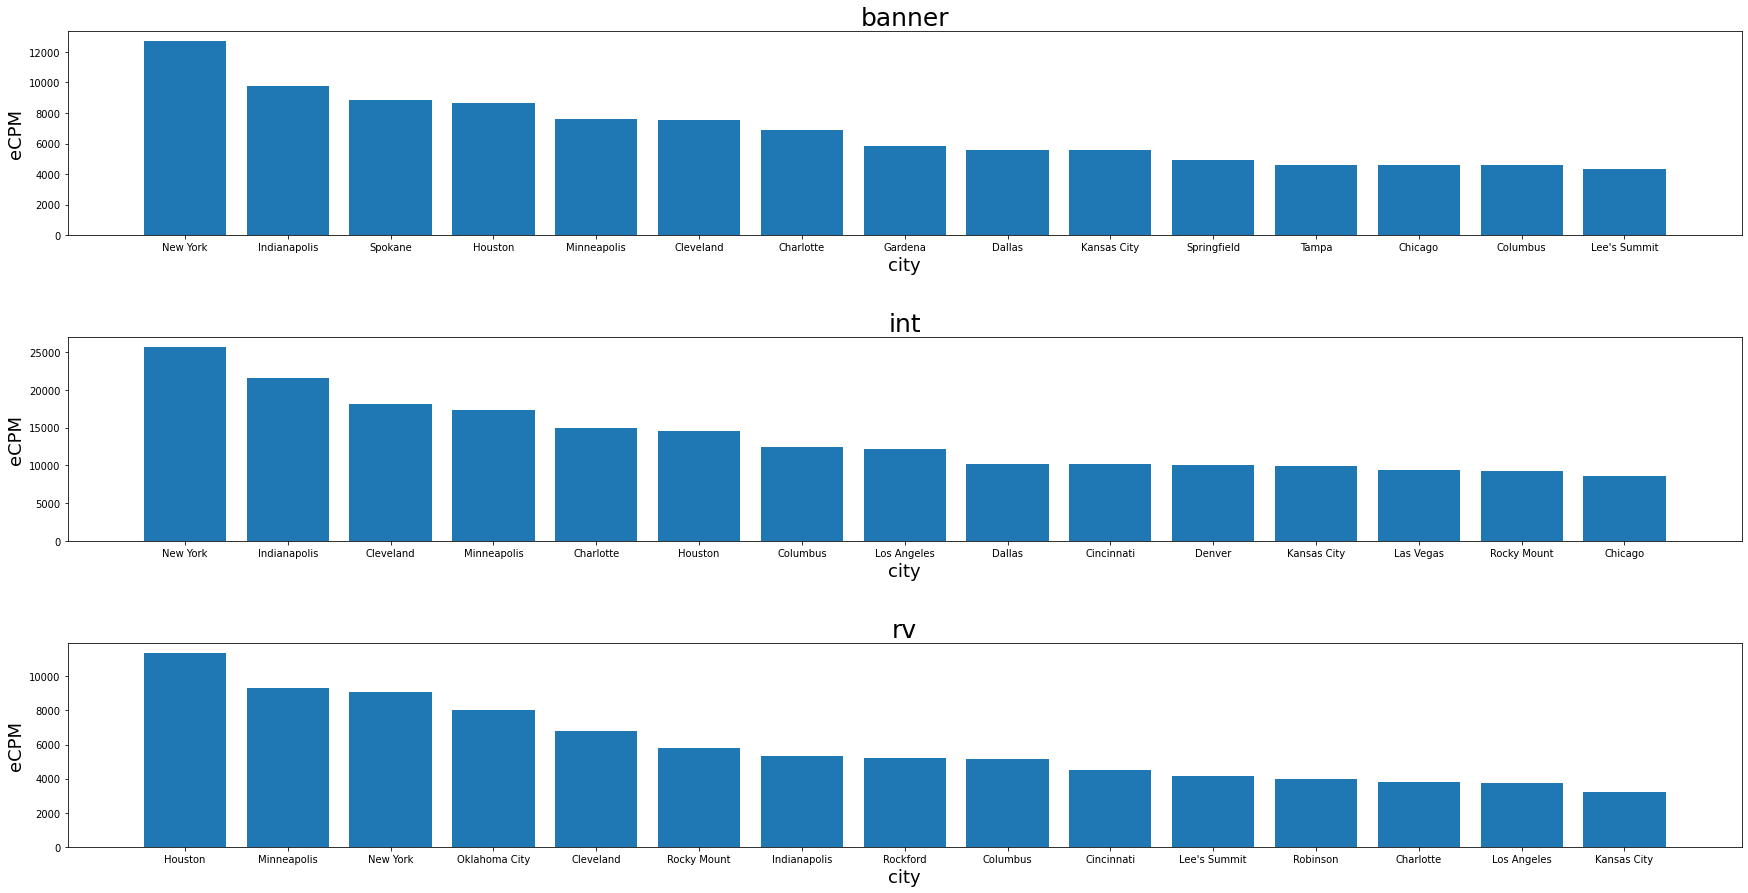

In [30]:
ad_type_eCPM_plots(ad_types, t_1c_city, top_n=15)

По версиям ОС:

In [31]:
t_1c_os = df.groupby(['ad_type', 'os_version']).eCPM.sum().sort_values(ascending=False)
t_1c_os

ad_type  os_version
int      12            704497.186955
         11            363634.932340
banner   12            363488.994005
rv       12            237592.766784
int      10            191795.052481
banner   11            116298.348409
rv       11            107291.532936
banner   10             85002.787602
int      9              78475.755227
rv       10             51470.090725
banner   9              34820.248723
rv       9              19809.863066
int      7.0             7813.966267
         8.0.0           6770.185185
         8.1.0           6016.150755
banner   8.1.0           2847.789158
         8.0.0           2804.951919
rv       8.0.0           2316.879156
         7.0             2071.224160
int      7.1.1           1203.362621
banner   7.0             1065.803185
rv       8.1.0            923.077220
int      7.1.2            837.482161
         6.0.1            579.568115
         5.0.2            329.325320
banner   7.1.1            300.135473
         7.1.2    

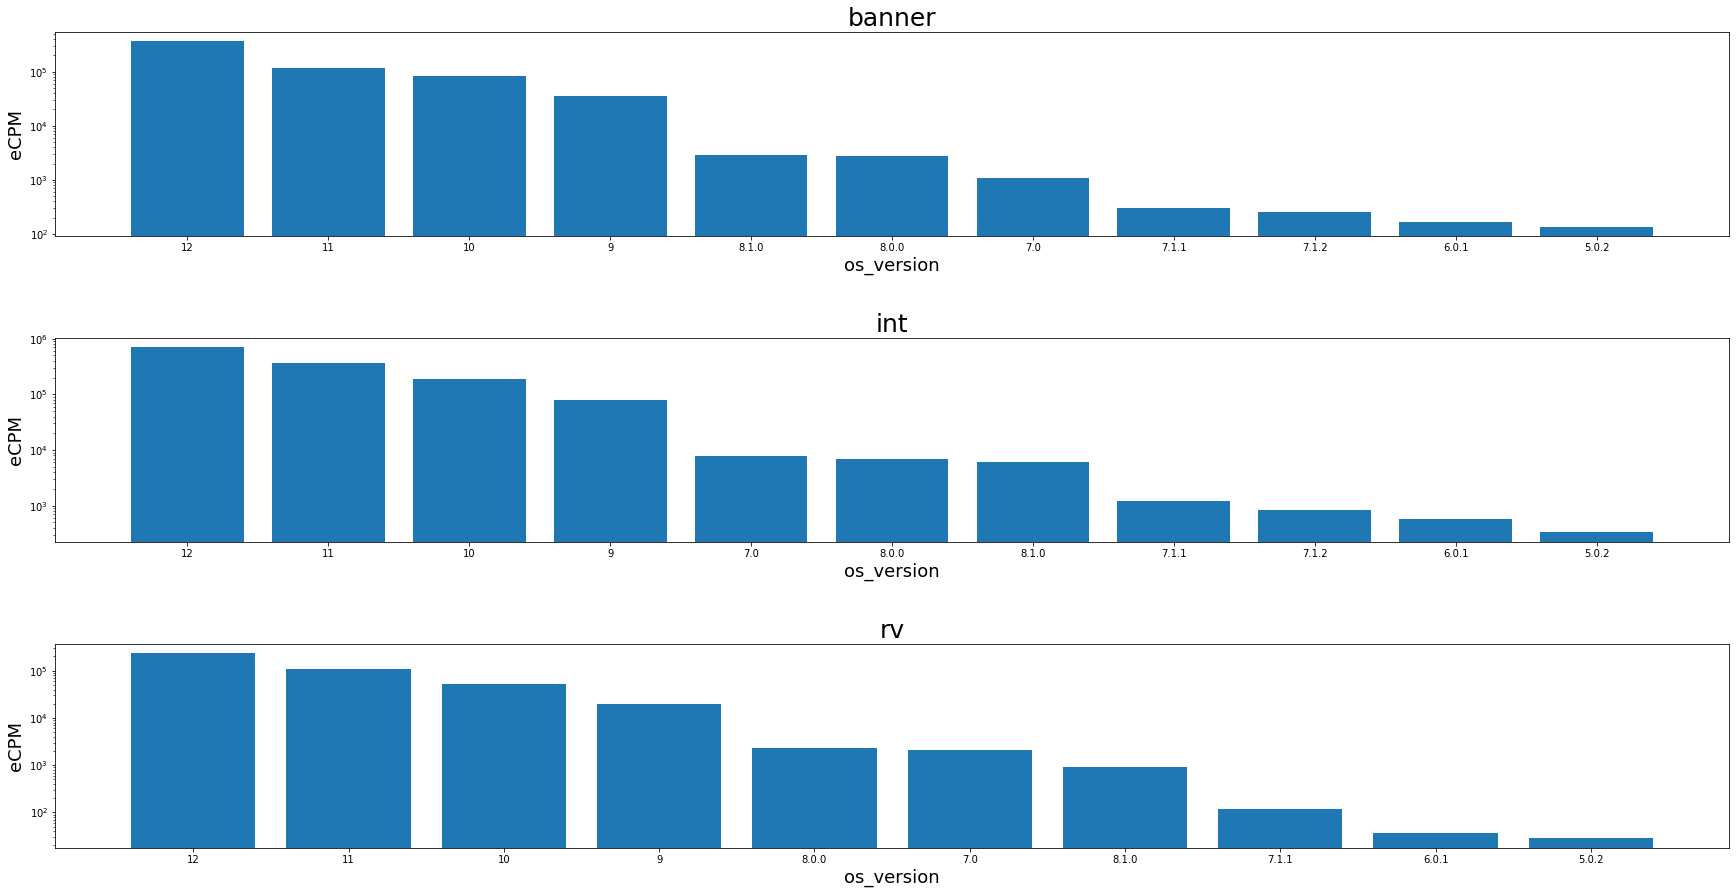

In [32]:
ad_type_eCPM_plots(ad_types, t_1c_os, logy=True)

Пользователи с 12 версия ОС приносят больше всего дохода для всех форматов рекламы

### 2

### Учесть статистическую значимость для п.1b (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.

Найдем количество данных для каждого города, по которым мы судили о средней составляющей eCPM для этого города

In [33]:
t_2_counts_city = (t_1c_city / t_1b_city).sort_values(ascending=False)
t_2_counts_city.head(3)

ad_type  city       
banner   New York       16801.0
         Minneapolis    12066.0
         Springfield     9769.0
Name: eCPM, dtype: float64

Найдем города с количеством данных хотя бы больше 50 и будем считать, что этого достаточно, чтобы считать среднюю составляющую eCPM для данного города достоверной

In [34]:
t_2_city = (t_1c_city / t_2_counts_city[t_2_counts_city > 50]).dropna().sort_values(ascending=False)
t_2_city.head(3)

ad_type  city         
rv       Oklahoma City    123.773099
         Houston          117.414860
         Cleveland        115.218102
Name: eCPM, dtype: float64

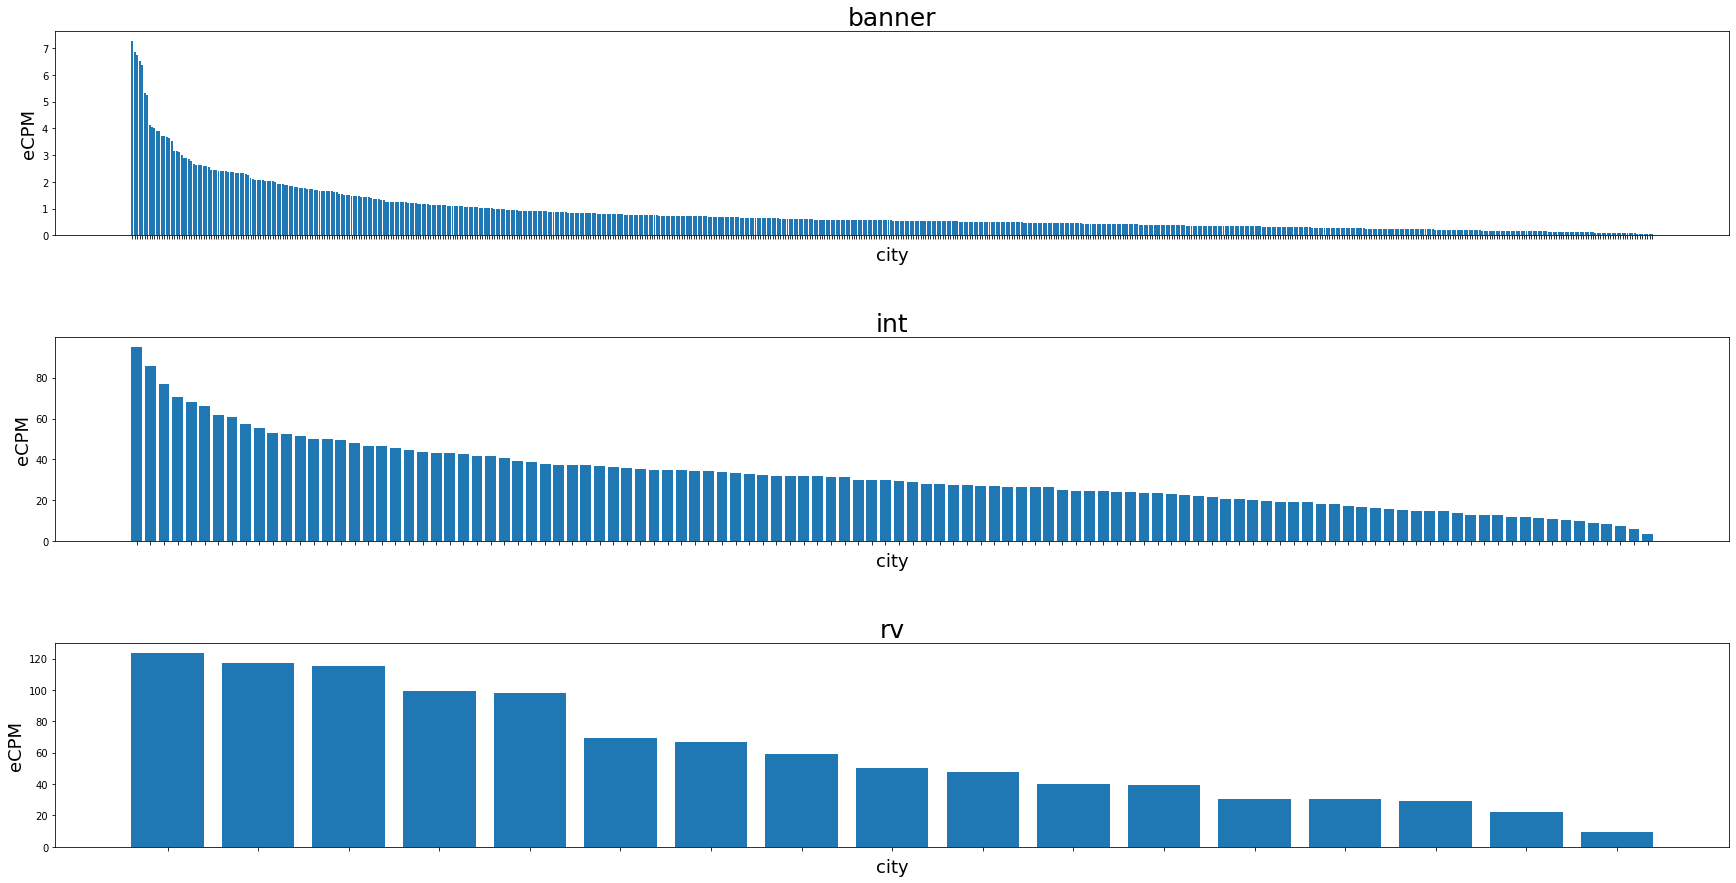

In [35]:
ad_type_eCPM_plots(ad_types, t_2_city, xtick=False)

Посмотрим для топ n городов для каждого формата рекламы

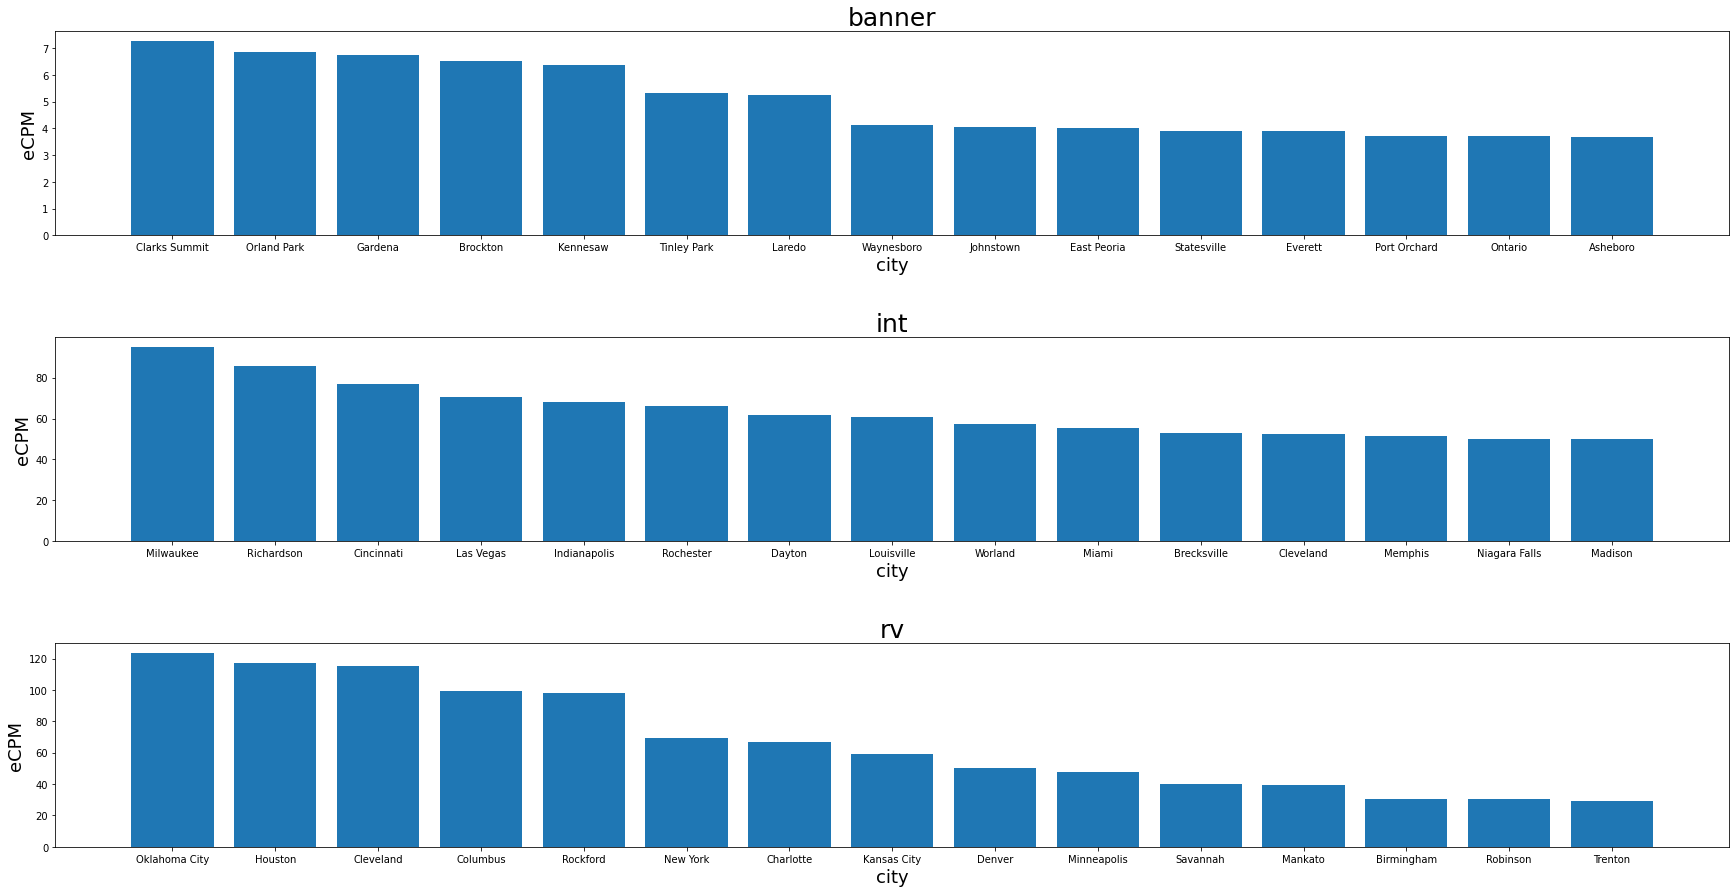

In [36]:
ad_type_eCPM_plots(ad_types, t_2_city, top_n=15)

Сравним результаты с п.1b

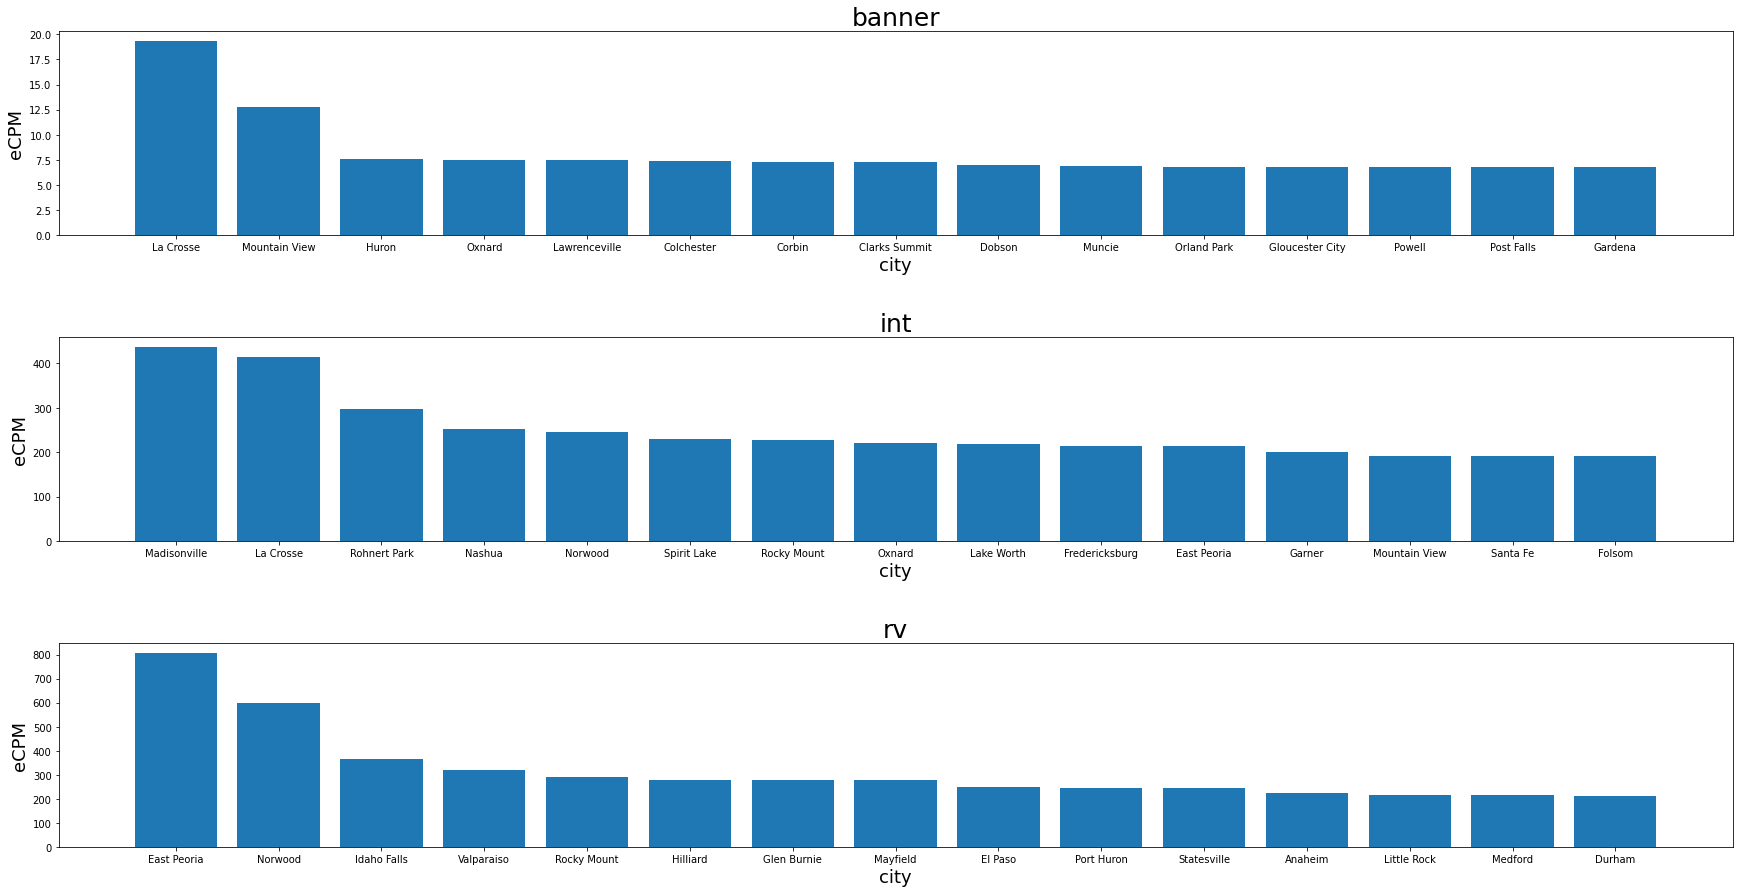

In [37]:
ad_type_eCPM_plots(ad_types, t_1b_city, top_n=15)

Различия максимальны, достоверные максимальные средние eCPM оказались в разы меньше, так же изменились лидеры города по среднему eCPM.

Аналогично для версий ОС:

In [38]:
t_2_counts_os = (t_1c_os / t_1b_os).sort_values(ascending=False)
t_2_counts_os.head(3)

ad_type  os_version
banner   12            387982.0
         11            196196.0
         10            143762.0
Name: eCPM, dtype: float64

In [39]:
t_2_os = (t_1c_os / t_2_counts_os[t_2_counts_os > 50]).dropna().sort_values(ascending=False)
t_2_os.head(3)

ad_type  os_version
rv       12            79.568911
         11            53.378872
         10            53.336882
Name: eCPM, dtype: float64

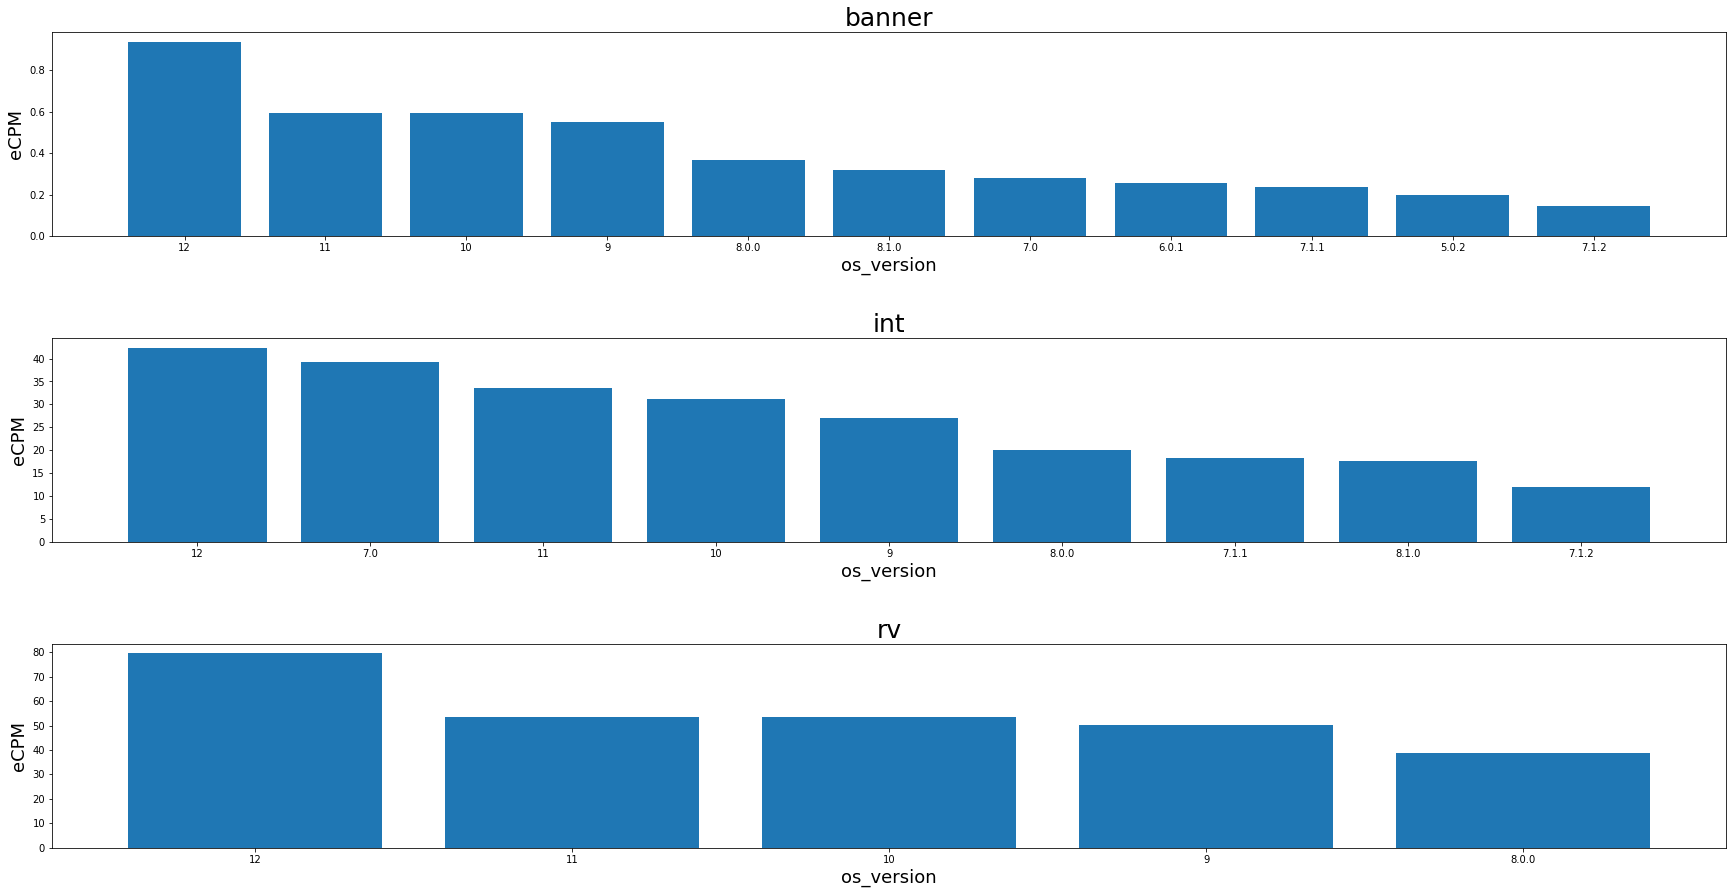

In [40]:
ad_type_eCPM_plots(ad_types, t_2_os)

Сравним результаты с п.1b

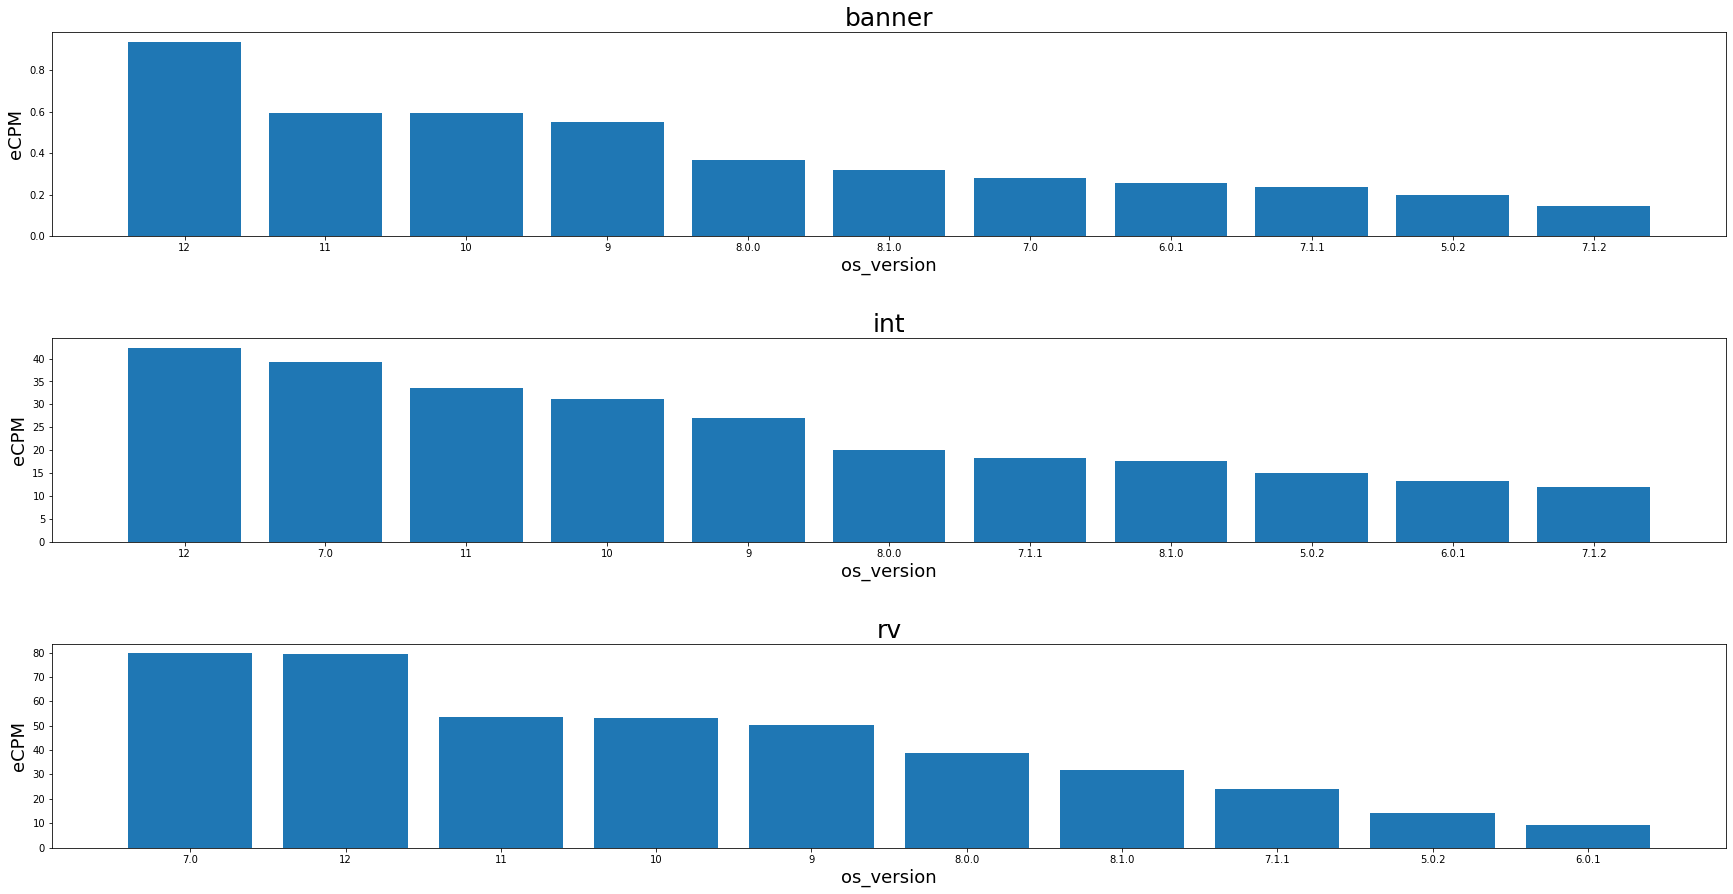

In [41]:
ad_type_eCPM_plots(ad_types, t_1b_os)

Сильнее всех результаты различаются для rv формата, так как данных там было меньше всего. В итоге по достоверным средним eCPM во всех форматах рекламы лидирует 12 версия ОС.

### Какой процент доходов содержит информацию о городе юзера (доп.)

In [42]:
df.city.notna().sum() / df.shape[0] * 100

62.36299223675965

### Зависит ли eCPM от времени дня (доп.)

Обучим модель градиентного бустинга CatBoostRegressor и найдём насколько влияет каждый параметр при предсказании eCPM, это же отвечает на вопрос как каждый параметр влияет на eCPM. Для обучения возьмём последнии 50000 данных.

In [62]:
X_train = df.tail(50000).drop('eCPM', axis=1).fillna('None')
Y_train = df.tail(50000)[['eCPM']]

In [63]:
cat_features = list(df.dtypes.index[df.dtypes == object])

In [64]:
def shap_for_cat(X_train, Y_train, cat_features):
  cat = CatBoostRegressor(random_state=42, verbose=False)
  cat.fit(X_train, Y_train, cat_features=cat_features)
  explainer = shap.TreeExplainer(cat)
  shap_values = explainer.shap_values(X_train)
  shap.summary_plot(shap_values, X_train, plot_type="bar", max_display = 50)
  return shap_values

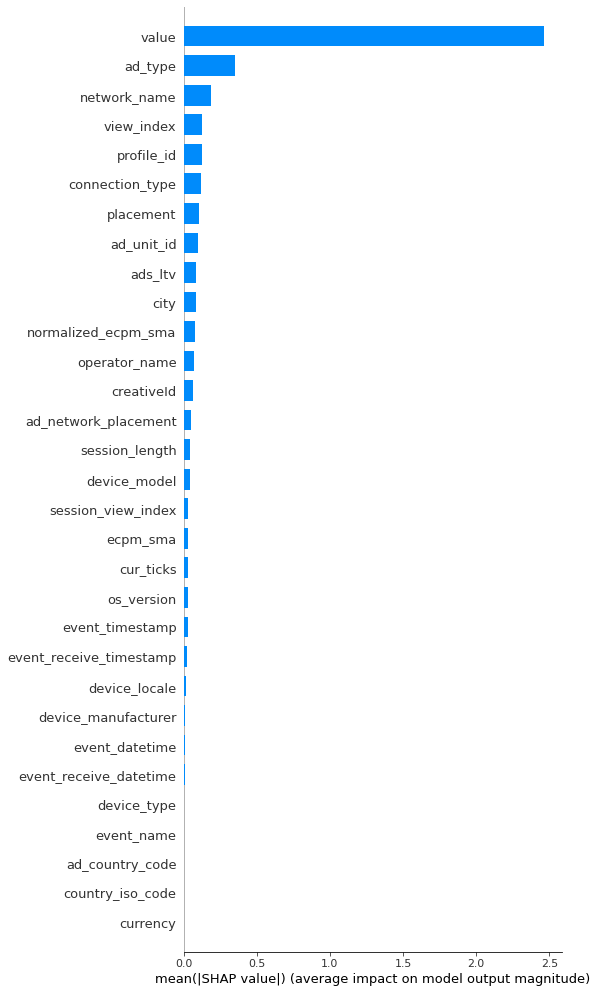

In [65]:
shap_values = shap_for_cat(X_train, Y_train, cat_features)

Судя по всему value это информация из json обьекта, которая максимально коррелирует с eCPM, поэтому для лучшего анализа повторим процедуру, но без неё

In [66]:
X_train = X_train.drop('value', axis=1)

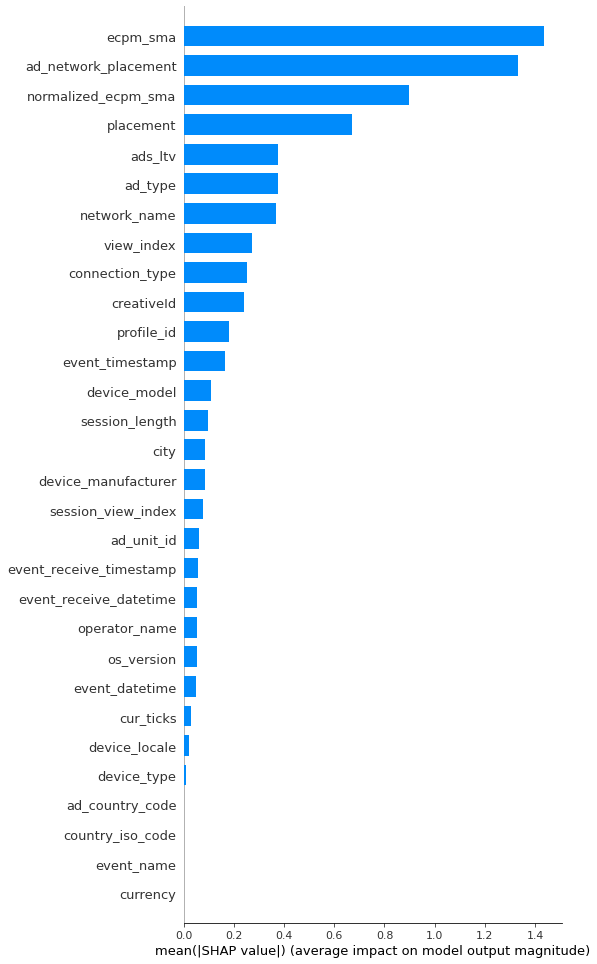

In [67]:
shap_values = shap_for_cat(X_train, Y_train, cat_features)

Видимо с ecpm_sma и normalized_ecpm_sma аналогичная ситуация

In [68]:
X_train = X_train.drop(['ecpm_sma', 'normalized_ecpm_sma'], axis=1)

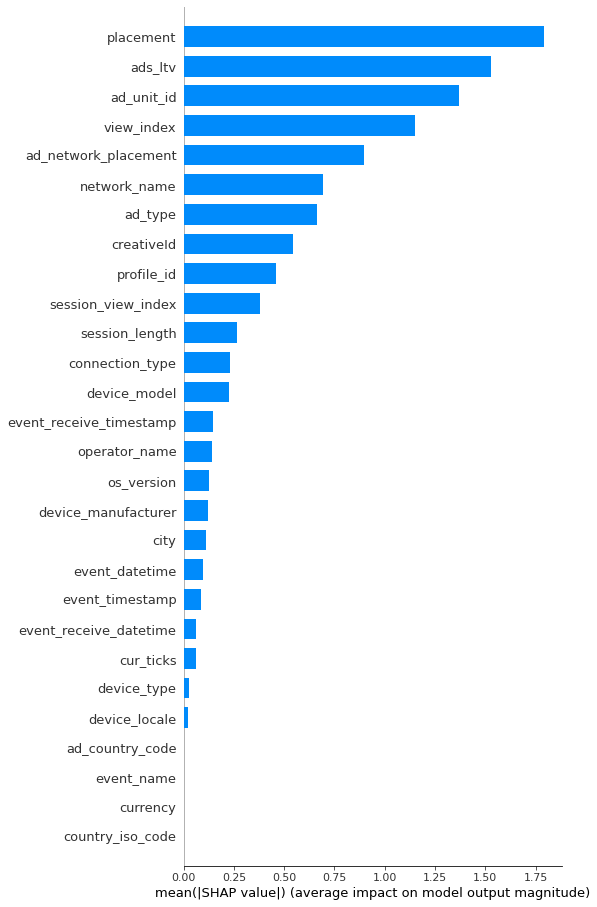

CPU times: user 6min 7s, sys: 3.16 s, total: 6min 10s
Wall time: 3min 15s


In [69]:
%%time

shap_values = shap_for_cat(X_train, Y_train, cat_features)

Видно, что от времени есть небольшая зависимость, но от некоторых других признаков эта зависимость гораздо больше.

Теперь посмотрим как именно влияют признаки, увеличивают или уменьшают eCPM

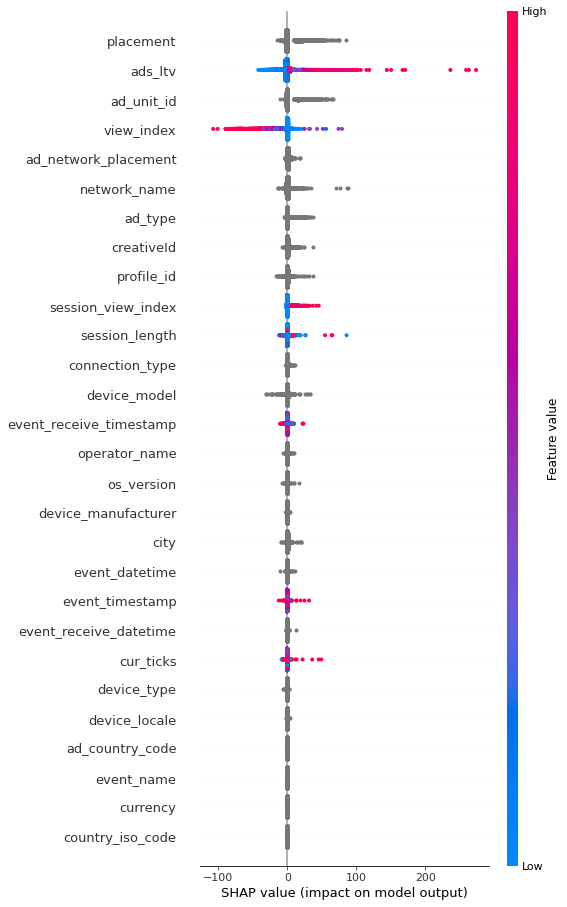

In [70]:
shap.summary_plot(shap_values, X_train, max_display = 50)

Интерпритация:

Тут станет понятно на 2 примерах:

С увеличением значения ads_ltv eCPM растёт, и наоборот, с уменьшением значения ads_ltv eCPM уменьшается.

С увеличением значения view_index eCPM уменьшается, и наоборот, с уменьшением значения view_index eCPM растёт.

Для серых значений, где данные были НЕ числовые, мы не можем сказать про влияние их значений на eCPM.

Видно, что все параметры ниже cur_ticks почти не вносят всклад в значение eCPM.

На самом деле можно доработать эту идею, хорошо обработав данные и оставив только нужные признаки, если преобразовать категориальные признаки в числовые(какие сможем), то можно посмотреть какой именно вклад они вносят в eCPM.

Так же можно поработать с идеей именно предсказания eCPM, а не исследования влияния на него признаков.

### 3

### Описать наблюдения и вывод по исследованию.

В данных присутствуют пропуски, для города их количество 38% от всех данных. Самый большой доход идёт от rv, самый маленький от banner. Самый большой доход идёт от 12 версии ОС, причём она заметно доминирует над другими. Самый доходный город New York. 

Мы проверили статистическую значимость для средних eCPM по городам, версиям ОС и отфильтровали города с маленьким количеством наблюдений. 

Так же было показано, как каждый признак предположительно влияет на eCPM.

Данных большое количество и в них можно найти много интересных зависимостей :)